In [16]:
import sys
sys.path.append('../implementation/')
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as sp
from tqdm import tqdm
import time
from monadjemi_competing_models import CompetingModels
import re

In [4]:
# Loading the STL Crimes underlying data and user interaction data
underlying_data = pd.read_csv('../data/stl_crimes/dots.csv')
underlying_data.set_index('id', drop=True, inplace=True)

interaction_data = pd.read_csv('../data/stl_crimes/stl_combined_interactions.csv')
interaction_data['interaction_session'] = interaction_data.apply(lambda row: ast.literal_eval(row.interaction_session), axis=1)
interaction_data['interaction_type_session'] = interaction_data.apply(lambda row: ast.literal_eval(row.interaction_type_session), axis=1)

In [5]:
underlying_data

,type,x,y
id,,,
0,2,-90.244464,38.583670
1,8,-90.187785,38.630310
2,2,-90.194706,38.631976
3,2,-90.238728,38.621549
4,6,-90.241504,38.651702
...,...,...,...
1946,2,-90.191101,38.635492
1947,2,-90.264296,38.584335
1948,6,-90.297848,38.591683


In [9]:
vastopolis_data_path = '../../active_visual_analytics/analysis/notebook/data'
vast_data = pd.read_pickle(f'{vastopolis_data_path}/microblogs_dataset.pkl')
vast_data_samples = np.load(f'{vastopolis_data_path}/experiment_1/sampled_ids_3000.npy')

In [10]:
vast_data

,post_id,user_id,post_date_time,location,text,latitude,longitude,porter_stems
0,0,3,5/18/2011 13:26,42.22717 93.33772,this convention filled with technology could b...,42.22717,93.33772,"[convent, fill, technolog, could, better, plan..."
1,1,3,5/10/2011 9:22,42.18881 93.35642,4 orang top scorer skrg 3 di antara nya pake ...,42.18881,93.35642,"[orang, top, scorer, skrg, di, antara, nya, pa..."
2,2,3,5/14/2011 9:22,42.22479 93.35922,Nike 'gana' el Mundial al patrocinador oficial...,42.22479,93.35922,"[nike, gana, el, mundial, al, patrocinador, of..."
3,3,3,5/6/2011 9:22,42.2469 93.32527,Positiiff mau nabung beli kaos adidas aslii...,42.24690,93.32527,"[positiiff, mau, nabung, beli, kao, adida, asl..."
4,4,3,5/19/2011 9:22,42.2354 93.35642,I kick it like Adidas,42.23540,93.35642,"[kick, like, adida]"
...,...,...,...,...,...,...,...,...
1023072,1023072,180464,5/2/2011 19:05,42.2814 93.24858,Als dit echt opgelost is wil ik alleen maar p...,42.28140,93.24858,"[al, dit, echt, opgelost, wil, ik, alleen, maa..."
1023073,1023073,180464,5/16/2011 19:05,42.25368 93.26695,Haha roast is hella funny . :D,42.25368,93.26695,"[haha, roast, hella, funni]"
1023074,1023074,180464,5/15/2011 19:05,42.19501 93.50979,LinkedIN profiel laat 1 ongelezen bericht in i...,42.19501,93.50979,"[linkedin, profiel, laat, ongelezen, bericht, ..."
1023075,1023075,180464,5/6/2011 19:05,42.24012 93.33166,soooorry guys my sister is an idiot.,42.24012,93.33166,"[soooorri, guy, sister, idiot]"


In [12]:
vast_data_sample = vast_data.iloc[vast_data_samples]

In [26]:
# preprocess
vast_data['text_processed'] = vast_data['text'].map(lambda x: re.sub('[,\.!?]', '', str(x)))
# Convert the titles to lowercase
vast_data['text_processed'] = vast_data['text_processed'].map(lambda x: x.lower())

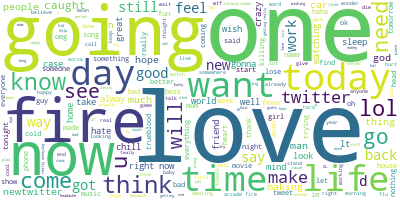

In [30]:
# Import the wordcloud library
from wordcloud import WordCloud# Join the different processed titles together.
long_string = ','.join(list(vast_data['text_processed'].values))# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

In [33]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data = vast_data.text_processed.values.tolist()
data_words = list(sent_to_words(data))# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/smonadjemi/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['convention', 'filled', 'technology', 'could', 'better', 'plan', 'leaving', 'anytime', 'soon']


In [34]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]


In [44]:
from pprint import pprint# number of topics
num_topics = 15# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.017*"convention" + 0.012*"day" + 0.010*"today" + 0.008*"awesome" + '
  '0.007*"ya" + 0.007*"que" + 0.006*"la" + 0.006*"filled" + 0.006*"de" + '
  '0.006*"newtwitter"'),
 (1,
  '0.020*"twitter" + 0.014*"today" + 0.011*"apple" + 0.010*"need" + 0.009*"go" '
  '+ 0.008*"iphone" + 0.008*"get" + 0.008*"phone" + 0.007*"back" + '
  '0.006*"food"'),
 (2,
  '0.013*"time" + 0.013*"boondocks" + 0.011*"watching" + 0.010*"good" + '
  '0.009*"one" + 0.009*"love" + 0.009*"know" + 0.008*"oh" + 0.006*"someone" + '
  '0.005*"find"'),
 (3,
  '0.017*"getting" + 0.015*"mind" + 0.014*"really" + 0.011*"live" + '
  '0.010*"annoying" + 0.010*"lose" + 0.009*"today" + 0.009*"day" + '
  '0.008*"night" + 0.008*"causing"'),
 (4,
  '0.013*"people" + 0.009*"like" + 0.008*"know" + 0.008*"love" + 0.008*"much" '
  '+ 0.007*"funny" + 0.007*"get" + 0.006*"one" + 0.006*"never" + '
  '0.006*"think"'),
 (5,
  '0.018*"life" + 0.015*"time" + 0.014*"one" + 0.013*"like" + 0.006*"debate" + '
  '0.006*"ausvotes" + 0.006*"

In [ ]:
lda_model.

In [53]:
from operator import itemgetter

In [54]:
lda_model[corpus[1]]

[(5, 0.438649), (6, 0.4983831)]

In [55]:
len(corpus)

1023077

In [56]:
max(lda_model[corpus[1]],key=itemgetter(1))[0]

6

In [58]:
vast_data['topic'] = vast_data.apply(lambda row: max(lda_model[corpus[row.name]],key=itemgetter(1))[0], axis=1)

<AxesSubplot:>

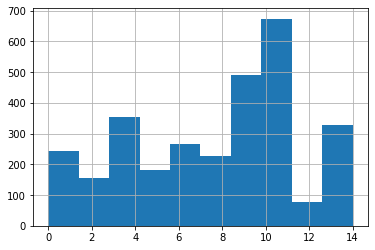

In [62]:
vast_data.iloc[vast_data_samples].topic.hist()

In [66]:
vast_data_sample = vast_data.iloc[vast_data_samples].copy()

In [67]:
vast_data_sample

,post_id,user_id,post_date_time,location,text,latitude,longitude,porter_stems,text_processed,topic
827141,827141,145812,5/19/2011 6:20,42.29909 93.31928,I hope everyone is having a wonderful Sunday. ...,42.29909,93.31928,"[hope, everyon, wonder, sunday, stori, today, ...",i hope everyone is having a wonderful sunday ...,14
159661,159661,28431,5/18/2011 10:13,42.20474 93.32567,McLaren 1304: Jenson had to go onto the run-of...,42.20474,93.32567,"[mclaren, jenson, go, onto, run, turn, one, st...",mclaren 1304: jenson had to go onto the run-of...,11
499973,499973,88167,5/18/2011 6:36,42.20857 93.37839,It is Monday.... what more can I say...,42.20857,93.37839,"[monday, say]",it is monday what more can i say,6
400022,400022,70573,5/19/2011 3:29,42.19541 93.4977,this loss of appetite getting really annoying ...,42.19541,93.49770,"[loss, appetit, get, realli, annoy, gah, stomach]",this loss of appetite getting really annoying ...,9
847951,847951,149504,5/19/2011 17:20,42.22183 93.39781,this a runny nose is making me crazy and im go...,42.22183,93.39781,"[runni, nose, make, crazi, im, go, bed]",this a runny nose is making me crazy and im go...,9
...,...,...,...,...,...,...,...,...,...,...
749641,749641,132152,5/19/2011 12:16,42.23628 93.32966,Required Viewing | 'Ladies and Gentlemen the ...,42.23628,93.32966,"[requir, view, ladi, gentlemen, fabul, stain]",required viewing | 'ladies and gentlemen the ...,14
973486,973486,171585,5/19/2011 21:50,42.22862 93.44469,I am throwing up being sick sucks,42.22862,93.44469,"[throw, sick, suck]",i am throwing up being sick sucks,9
225477,225477,40107,5/18/2011 14:50,42.1897 93.47025,Is it too Kate now to do my #followfriday #ff ...,42.18970,93.47025,"[kate, followfriday, ff, much]",is it too kate now to do my #followfriday #ff ...,7
414682,414682,73229,5/19/2011 18:07,42.24425 93.54015,Nothing better than a long brisk walk when the...,42.24425,93.54015,"[noth, better, long, brisk, walk, weather, like]",nothing better than a long brisk walk when the...,5


In [68]:
# list of keyword stems indicating a tweet is relevant
keywords = ['sore', 'throat', 'fever', 'fatigu', 'cough', 'short', 'breath', 'chill', 'sick', 
            'pain', 'diarrhea', 'stomach', 'sweat', 'pneumonia', 'flu', 'ach', 'nausea', 'vomit', 
            'nauseou', 'declin', 'health', 'headach', 'nose', 'runni']

# Label data points as relevant (1) or irrelevant (0) according to the keywords above
vast_data_sample['label'] =  vast_data_sample.apply(lambda row: int(any([w in keywords for w in row.porter_stems])), axis=1)

<AxesSubplot:>

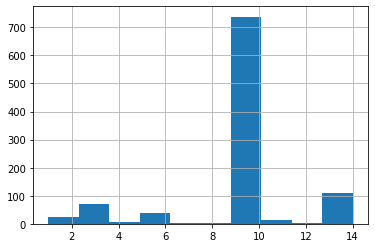

In [72]:
vast_data_sample[vast_data_sample.label==1].topic.hist()

In [75]:
vast_data_sample = vast_data_sample.reset_index()

In [83]:
d = vast_data_sample[['latitude', 'longitude', 'topic']]

In [84]:
d

,latitude,longitude,topic
0,42.29909,93.31928,14
1,42.20474,93.32567,11
2,42.20857,93.37839,6
3,42.19541,93.49770,9
4,42.22183,93.39781,9
...,...,...,...
2995,42.23628,93.32966,14
2996,42.22862,93.44469,9
2997,42.18970,93.47025,7
2998,42.24425,93.54015,5


In [85]:
interaction_data

,user,task,interaction_session,interaction_type_session
0,15,geo-based,"[828, 19, 389, 478, 118, 865, 865, 828, 19, 38...","[click, click, click, click, click, click, cli..."
1,14,geo-based,"[1102, 1102, 828, 19, 389, 478, 865, 544, 118,...","[click, click, click, click, click, click, cli..."
2,28,geo-based,"[828, 19, 389, 478, 478, 865, 544, 118, 1102, ...","[click, click, click, click, click, click, cli..."
3,16,geo-based,"[19, 828, 828, 544, 865, 478, 389, 118, 118, 1...","[click, click, click, click, click, click, cli..."
4,17,geo-based,"[828, 19, 389, 118, 478, 544, 865, 1102, 1025,...","[click, click, click, click, click, click, cli..."
...,...,...,...,...
73,21,type-based,"[5, 1671, 817, 1751, 727, 529, 10, 1758, 471, ...","[click, click, click, click, click, click, cli..."
74,23,type-based,"[5, 1671, 1751, 817, 727, 529, 10, 10, 10, 175...","[click, click, click, click, click, click, cli..."
75,22,type-based,"[1942, 1152, 471, 1758, 10, 529, 727, 817, 175...","[click, click, click, click, click, click, cli..."
76,19,type-based,"[727, 529, 10, 1758, 471, 817, 1751, 1671, 5, ...","[click, click, click, click, click, click, cli..."


In [98]:
id_to_index = {vast_data_samples[i]: i for i in range(len(vast_data_samples))}

In [86]:
ui_sessions = pd.read_pickle('../../active_visual_analytics/analysis/notebook/data/experiment_1/userstudy_sessions.pkl')
ui_bms = pd.read_pickle('../../active_visual_analytics/analysis/notebook/data/experiment_1/userstudy_bookmarks.pkl')
ui_hovers = pd.read_pickle('../../active_visual_analytics/analysis/notebook/data/experiment_1/userstudy_hovers.pkl')

In [99]:
df_ui_bm_formatted = pd.DataFrame()
for uid, row in ui_sessions.iterrows():
    df_temp = ui_bms[(ui_bms.session_id == uid) & (ui_bms.feedback == 'bookmark')]
    l_interaction_session = []
    l_interaction_type_session = []
    for _, bm in df_temp.iterrows():
        l_interaction_session.append(id_to_index[bm.point_id])
        l_interaction_type_session.append(bm.feedback)
    session = {'user': uid, 
               'experimental_group': row.active_search_condition, 
               'interaction_session': l_interaction_session, 
               'interaction_type_session': l_interaction_type_session}
    df_ui_bm_formatted = df_ui_bm_formatted.append(session, ignore_index=True)
    

In [100]:
df_ui_bm_formatted

,experimental_group,interaction_session,interaction_type_session,user
0,control,"[2011, 749, 1352, 1352, 1352, 678, 2932, 903, ...","[bookmark, bookmark, bookmark, bookmark, bookm...",ottNn7b8Wt1EL-I0bfFbOA
1,control,"[395, 2319, 1315, 2376, 997, 2001, 162, 2137, ...","[bookmark, bookmark, bookmark, bookmark, bookm...",Tn8m4yLs6E0GDO6sggwYTw
2,control,"[513, 162, 1643, 2041, 1327, 1969, 427, 2547, ...","[bookmark, bookmark, bookmark, bookmark, bookm...",SW8GwZ1tt4Z5DiK3J4rw2g
3,control,"[1694, 2912, 709, 1816, 2164, 1447, 504, 486, ...","[bookmark, bookmark, bookmark, bookmark, bookm...",POzOiTeXMSdTEbmSmI4wpg
4,control,"[2120, 987, 327, 2783, 2529, 41, 2927, 1999, 7...","[bookmark, bookmark, bookmark, bookmark, bookm...",n-Oq8YP_DhsByGZyxuGroQ
...,...,...,...,...
125,control,"[344, 162, 2001, 513, 652, 2017, 372, 672, 548...","[bookmark, bookmark, bookmark, bookmark, bookm...",xFutzVnyUPJa1FdcHDBuOA
126,control,"[344, 1678, 2288, 44, 1673, 2976, 811, 1932, 4...","[bookmark, bookmark, bookmark, bookmark, bookm...",5GV8_vl7CrnU1n_e3BYAyA
127,control,"[1368, 2260, 1274, 2870, 2013, 928, 2490, 164,...","[bookmark, bookmark, bookmark, bookmark, bookm...",RZKgmh54IrTo2bVMpg0L9w
128,control,"[1421, 1342, 757, 520, 449, 2131, 1119, 2587, ...","[bookmark, bookmark, bookmark, bookmark, bookm...",CxFmhMS5PYYF-f2YdntYMg


In [101]:
df_ui_bm_formatted.to_pickle('../data/vast_2011_challenge/bookmark_interactions.pkl')

In [103]:
df_ui_hovers_formatted = pd.DataFrame()
for uid, row in ui_sessions.iterrows():
    df_temp = ui_hovers[(ui_hovers.session_id == uid) & (ui_hovers.feedback == 'hover_circle')]
    l_interaction_session = []
    l_interaction_type_session = []
    for _, bm in df_temp.iterrows():
        l_interaction_session.append(id_to_index[bm.point_id])
        l_interaction_type_session.append(bm.feedback)
    session = {'user': uid, 
               'experimental_group': row.active_search_condition, 
               'interaction_session': l_interaction_session, 
               'interaction_type_session': l_interaction_type_session}
    df_ui_hovers_formatted = df_ui_hovers_formatted.append(session, ignore_index=True)
    

In [105]:
df_ui_hovers_formatted.to_pickle('../data/vast_2011_challenge/hover_interactions.pkl')